Project 1 Submission

* Student name: Jenny Kreiger
* Student pace: full time
* Scheduled project review date/time: Tuesday, 10/15/19, 08:30 PDT
* Instructor name: Victor Geislinger
* Blog post URL: 

# Introduction

This project uses data from the Northwind database to answer questions about the (fictional) Northwind company's discounting strategy. [Microsoft created the Northwind database](https://docs.microsoft.com/en-us/dotnet/framework/data/adonet/sql/linq/downloading-sample-databases) to use as a sample in its Access and SQL Server applications; the database represents internal records for a specialty food import/export business. The database contains tables for customer orders, details on the products themselves, and information about employees and customers, among other things. This project focuses on the data about orders and products.

For this project, I am examining the Northwind company's discounting strategy using hypothesis testing. In particular, I want to determine what effect (if any) discounts have on the quantities and total dollar values of products that Northwind customers order. I am also interested in whether any one discount level (5%, 10%, etc.) is more or less effective at raising order quantities or values than the others, or whether there is a category of products (Beverages, Condiments, etc.) where discounting is more or less effective compared to the other categories.

My findings are summarized in the **Interpretations and recommendations** section below.

# Extract the data

To start off, I will import the packages I need. Note that I am importing some custom functions for conducting Welch's t-test (`welch_functions`); these were created as part of my bootcamp curriculum at Flatiron School.

In [1]:
# Import needed packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
sns.set_context('talk')

import scipy.stats as stats
import sqlite3

from welch_functions import *

import scipy.stats as stats
import pingouin as pg

import statsmodels.api as sm
from statsmodels.stats.power import TTestIndPower, TTestPower
from statsmodels.formula.api import ols
from statsmodels.stats.multicomp import pairwise_tukeyhsd, MultiComparison

from itertools import combinations

import warnings
warnings.simplefilter("ignore")

The data is stored in a database in the same repository as this notebook. Here I connect to the database:

In [2]:
# Set up connection to the database
conn = sqlite3.connect('Northwind_small.sqlite')
cur = conn.cursor()

Having looked at the database schema (you can view a diagram in the repo), I know that I want to pull data from a couple of tables at once. The query below takes most of the data from the `OrderDetail` table and joins on some fields about product names and categories from the `Product` and `Category` tables.

In [3]:
# Query the database and load the data
cur.execute("""
    SELECT o.OrderID, o.ProductID, o.UnitPrice, o.Quantity, o.Discount,
        p.ProductName, c.ID AS CategoryID, c.CategoryName
    FROM OrderDetail o
        JOIN Product p
            ON o.ProductID = p.ID
        JOIN Category c
            ON p.CategoryID = c.ID
            ;""")
df = pd.DataFrame(cur.fetchall())
df.columns = [x[0] for x in cur.description]
df.head()

,OrderId,ProductId,UnitPrice,Quantity,Discount,ProductName,CategoryID,CategoryName
0,10248,11,14.0,12,0.0,Queso Cabrales,4,Dairy Products
1,10248,42,9.8,10,0.0,Singaporean Hokkien Fried Mee,5,Grains/Cereals
2,10248,72,34.8,5,0.0,Mozzarella di Giovanni,4,Dairy Products
3,10249,14,18.6,9,0.0,Tofu,7,Produce
4,10249,51,42.4,40,0.0,Manjimup Dried Apples,7,Produce


A quick look at the DataFrame above reveals that each row represents an instance of a product in an order. Each `OrderId` can appear more than once (one time for each distinct product in that order). Each `ProductId` can also appear multiple times in the dataset, but a given ID will probably not appear more than once per order (unless, for some reason, a product was purchased at two different prices in the same order, which seems unlikely). 

A product may be assigned more than one unique `UnitPrice` across different orders. The `UnitPrice` field is independent of the `Discount` field&mdash;that is, `UnitPrice` represents the unit price of an item _before_ any discounts are applied.

Before moving on, I want to take a quick look at some summary statistics and value counts.

In [4]:
# View summary statistics
df.describe()

,OrderId,ProductId,UnitPrice,Quantity,Discount,CategoryID
count,2155.000000,2155.000000,2155.000000,2155.000000,2155.000000,2155.000000
mean,10659.375870,40.793039,26.218520,23.812993,0.056167,4.135499
std,241.378032,22.159019,29.827418,19.022047,0.083450,2.378567
min,10248.000000,1.000000,2.000000,1.000000,0.000000,1.000000
25%,10451.000000,22.000000,12.000000,10.000000,0.000000,2.000000
50%,10657.000000,41.000000,18.400000,20.000000,0.000000,4.000000
75%,10862.500000,60.000000,32.000000,30.000000,0.100000,6.000000
max,11077.000000,77.000000,263.500000,130.000000,0.250000,8.000000


# Explore and transform the data

There are a couple of transformations I want to apply to the data before moving any further. 

Knowing that I want to subset the data by whether discounts were applied or not, I will add a boolean column to indicate whether the value in the `Discount` column is 0 or not.

Then I will add a column that calculates the total dollar price of a product in an order by multiplying its `UnitPrice` by its `Quantity` by `Discount`, if any. This will let me examine whether discounts increase the total dollar amount customer spend on products or in orders.

In [5]:
# Add a boolean column to help filter discounted from non-discounted items
df['Discount_bool'] = df.apply(lambda row: 1 if row.Discount > 0 else 0, axis=1)

Now I can use the boolean column to calculate the total price in dollars of a product, accounting for a discount if there is one:

In [6]:
# Add a column to calculate the price of a product in an order
# (unit price * quantity)
df['ProductTotal'] = df.UnitPrice * df.Quantity
for index in df.index:
    if df.loc[index, 'Discount_bool'] != 0:
        df['ProductTotal'] = df.UnitPrice * df.Quantity * (1-df.Discount)

That should do it. Let's take a look:

In [7]:
# View the data
df.head(10)

,OrderId,ProductId,UnitPrice,Quantity,Discount,ProductName,CategoryID,CategoryName,Discount_bool,ProductTotal
0,10248,11,14.0,12,0.00,Queso Cabrales,4,Dairy Products,0,168.00
1,10248,42,9.8,10,0.00,Singaporean Hokkien Fried Mee,5,Grains/Cereals,0,98.00
2,10248,72,34.8,5,0.00,Mozzarella di Giovanni,4,Dairy Products,0,174.00
3,10249,14,18.6,9,0.00,Tofu,7,Produce,0,167.40
4,10249,51,42.4,40,0.00,Manjimup Dried Apples,7,Produce,0,1696.00
5,10250,41,7.7,10,0.00,Jack's New England Clam Chowder,8,Seafood,0,77.00
6,10250,51,42.4,35,0.15,Manjimup Dried Apples,7,Produce,1,1261.40
7,10250,65,16.8,15,0.15,Louisiana Fiery Hot Pepper Sauce,2,Condiments,1,214.20
8,10251,22,16.8,6,0.05,Gustaf's Knäckebröd,5,Grains/Cereals,1,95.76
9,10251,57,15.6,15,0.05,Ravioli Angelo,5,Grains/Cereals,1,222.30


To check whether discounts were handled correctly, look at rows 5 and 6, for instance. The `ProductTotal` for row 5 is 77.00 (= 7.7 * 10), and the total for row 6 is 1261.40 (= 42.4 * 35 * (1-0.15)). 

Let's take one last look at summary statistics before moving on:

In [8]:
# Check summary statistics
df.describe()

,OrderId,ProductId,UnitPrice,Quantity,Discount,CategoryID,Discount_bool,ProductTotal
count,2155.000000,2155.000000,2155.000000,2155.000000,2155.000000,2155.000000,2155.000000,2155.000000
mean,10659.375870,40.793039,26.218520,23.812993,0.056167,4.135499,0.388863,587.374960
std,241.378032,22.159019,29.827418,19.022047,0.083450,2.378567,0.487605,969.224235
min,10248.000000,1.000000,2.000000,1.000000,0.000000,1.000000,0.000000,4.800000
25%,10451.000000,22.000000,12.000000,10.000000,0.000000,2.000000,0.000000,147.000000
50%,10657.000000,41.000000,18.400000,20.000000,0.000000,4.000000,0.000000,337.750000
75%,10862.500000,60.000000,32.000000,30.000000,0.100000,6.000000,1.000000,656.000000
max,11077.000000,77.000000,263.500000,130.000000,0.250000,8.000000,1.000000,15810.000000


Since most of my questions have to do with `Quantity`, I should confirm that it will meet our assumption for normality&mdash;not that the values of `Quantity` themselves are normally distributed, but that the means of many samples drawn from those values would have a normal distribution converging around the "true" mean.

I can test this easily by drawing a number of random samples from the `Quantity` values and then plotting a histogram to confirm that they are normally distributed.

In [9]:
# Get just the `Quantity` values
quantities = df.Quantity

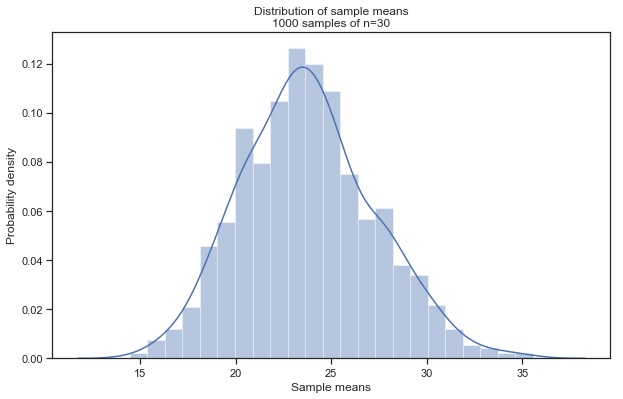

In [10]:
# Plot the means of 1000 samples of size 30
sample_means = []
for n in range(1000):
    sample = np.random.choice(quantities, 30)
    mean = np.mean(sample)
    sample_means.append(mean)

plt.figure(figsize=(10,6))
sns.distplot(sample_means)
plt.xlabel('Sample means')
plt.ylabel('Probability density')
plt.title('Distribution of sample means\n1000 samples of n=30')
plt.show();

Even with the relatively small and arbitrary sample size of 30, that looks normal enough to me. I also think it is reasonable to assume that the observations in the dataset are independent. I don't know whether products were randomly selected for the application of discounts (there was probably some strategy involved), but I will assume that the data passes the assumption of randomness as well.

I will re-check for these assumptions as I manipulate the data for subsequent hypothesis tests.

# Create needed functions

Describe custom function needs.

In [11]:
# Define a function to run Welch's t-test, evaluate and print results
def run_welch(a, b, two_sided=False, alpha=0.05):
    """Perform Welch's t-test and compare p-value to given alpha.
       a: first sample (one-dimensional array)
       b: second sample (one-dimensional array)
       two-sided: whether the t-test should be two-sided or not (boolean)
       alpha: alpha value for comparison with calculated p-value
       
       Dependencies: welch_functions.py"""
    
    # Calculate p-value
    p_value = p_value_welch_ttest(a, b, two_sided=False)
    
    # Evaluate and print results
    if p_value < alpha:
        print('Null hypothesis rejected (p_value = {})'.format(p_value))
    else:
        print('Fail to reject null hypothesis (p_value = {})'.format(p_value))
    

In [102]:

def Cohen_d(group1, group2):

    diff = group1.mean() - group2.mean()

    n1, n2 = len(group1), len(group2)
    var1 = group1.var()
    var2 = group2.var()

    pooled_var = (n1 * var1 + n2 * var2) / (n1 + n2)
    
    d = diff / np.sqrt(pooled_var)
    
    return d

In [12]:
# Define a function to plot KDEs comparing discounted items to 
# non-discounted items
# IS THERE A WAY to generalize this to other comparisons (not just ones
# that involve a % level)?
def compare_quantity_kdes(non_discounted, discounted, percent):
    """Plots KDEs for quantities of non-discounted items and discounted 
       items at a specified discount level.
       non_discounted: 1-D array
       discounted: 1-D array
       percent: the value of the discount (for labeling purposes)
       Dependencies: matplotlib, seaborn"""
    
    plt.figure(figsize=(8,6))
    sns.distplot(non_discounted, label='No discount')
    sns.distplot(discounted, label='{}}% discount'.format(percent))
    plt.axvline(x=np.mean(non_discounted), linestyle='--', 
                label='Mean, no discount')
    plt.axvline(x=np.mean(discounted), linestyle='--', color='orange', 
                label='Mean, {}% discount'.format(percent))
    plt.legend()
    plt.title('Comparing discounted v. non-discounted products')
    plt.ylabel('Probability density')
    plt.show();



# Hypothesis tests

## Hyp 1 with outliers removed

Does discount amount have a statistically significant effect on the quantity of a product in an order? If so, at what level(s) of discount?

This test uses the following hypotheses to begin with:

H<sub>0</sub>: mean quantity ordered without discount == mean quantity ordered with discount

H<sub>a</sub>: mean quantity ordered without discount < mean quantity ordered with discount

If discounts are determined to have a significant effect on quantity, then I will re-phrase my hypotheses for subsequent tests to determine which specific discount amounts have significant effects on quantity.

This initial test will be a one-way ANOVA using the following parameters:

In [66]:
# Set alpha and power
alpha = 0.05
power = 0.8

First I want to check the distribution of quantity values to see if they are normally distributed or if there are outliers that could have a big impact on variance.

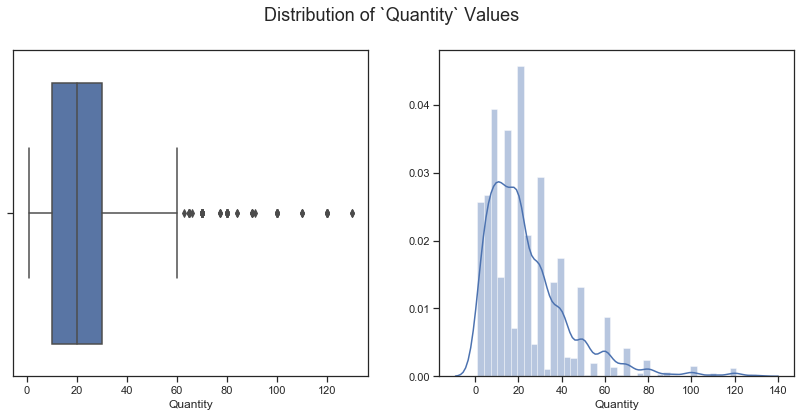

In [65]:
# Create boxplot and distplot for df.Quantity
fig, axes = plt.subplots(1, 2, figsize=(14, 6))
ax1 = sns.boxplot(df.Quantity, ax=axes[0])
ax2 = sns.distplot(df.Quantity, ax=axes[1])
plt.suptitle('Distribution of `Quantity` Values', fontsize=18);

The boxplot shows that there are some values lying outside of the whiskers, which represent 1.5 times the interquartile range for this data. The distplot gives another perspective on this positive skew. 

To ensure that outliers are not affecting the results of my analysis, I will drop any observations with `Quantity` values over 60 (see how I calculated this value below).

In [69]:
# Calculate the cutoff point (1.5*IQR + 75th percentile)
iqr = stats.iqr(df.Quantity)
upper_quartile = 30
cutoff = 1.5 * iqr + upper_quartile
cutoff

60.0

In [39]:
# Remove outliers
df_trimmed = df[df.Quantity <= cutoff]
df_trimmed.describe()

,OrderId,ProductId,UnitPrice,Quantity,Discount,CategoryID,Discount_bool,ProductTotal
count,2068.000000,2068.000000,2068.000000,2068.000000,2068.000000,2068.000000,2068.000000,2068.000000
mean,10659.126209,40.845745,26.295909,21.290135,0.055073,4.132495,0.379594,532.440782
std,241.028049,22.184800,30.250406,14.329793,0.083188,2.378310,0.485403,900.509713
min,10248.000000,1.000000,2.000000,1.000000,0.000000,1.000000,0.000000,4.800000
25%,10451.750000,22.000000,12.000000,10.000000,0.000000,2.000000,0.000000,142.500000
50%,10657.000000,41.000000,18.400000,20.000000,0.000000,4.000000,0.000000,315.000000
75%,10861.000000,60.000000,32.000000,30.000000,0.100000,6.000000,1.000000,608.000000
max,11077.000000,77.000000,263.500000,60.000000,0.250000,8.000000,1.000000,15810.000000


I now believe that I have data is that (roughly) normally distributed, independent, and random. It's time for the ANOVA test on the `Discount_bool` column to see if having a discount of any value has a significant effect on quantity.

In [70]:
# Run ANOVA 
formula = 'Quantity ~ C(Discount_bool)'

import statsmodels.api as sm
from statsmodels.formula.api import ols

lm = ols(formula, df_trimmed).fit()
table = sm.stats.anova_lm(lm, typ=2)
table

,sum_sq,df,F,PR(>F)
C(Discount_bool),5470.464835,1.0,26.975409,2.262989e-07
Residual,418973.453927,2066.0,NaN,NaN


The very low p-value tells me that I can reject the null hypothesis; discounted products are purchased in greater quantities than non-discounted products.

In [72]:
# Subset the data based on `Discount`
df_no_discount = df_trimmed[df_trimmed.Discount == 0]
df_discount = df_trimmed[df_trimmed.Discount != 0]

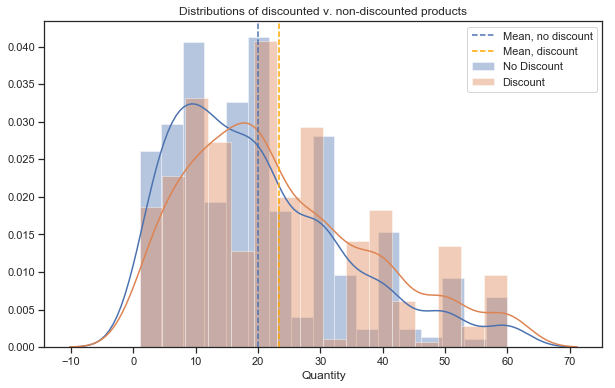

In [81]:
plt.figure(figsize=(10,6))
sns.distplot(df_no_discount.Quantity, label='No Discount')
sns.distplot(df_discount.Quantity, label='Discount')
plt.axvline(x=np.mean(df_no_discount.Quantity), linestyle='--', 
            label='Mean, no discount')
plt.axvline(x=np.mean(df_discount.Quantity), linestyle='--', color='orange',
            label='Mean, discount')
plt.legend()
plt.title('Distributions of discounted v. non-discounted products')
plt.show();

In [74]:
stats.levene(df_no_discount.Quantity, df_discount.Quantity)

LeveneResult(statistic=2.6481610511325036, pvalue=0.10382224766808272)

Because the Levene test shows that the two samples have equivalent variance, I can use Cohen's _d_ to calculate the effect size, which in turn will let me calculate the statistical power my test will have given my current alpha, sample sizes, and effect size.

In [84]:
pop_std = np.std(df_trimmed.Quantity)
no_disc_mean = np.mean(df_no_discount.Quantity)
disc_mean = np.mean(df_discount.Quantity)
print('Raw effect size:', disc_mean - no_disc_mean)

d = (disc_mean - no_disc_mean) / pop_std
print('Cohen\'s d:', d)

Raw effect size: 3.3515000173756775
Cohen's d: 0.2339399191060167


In [83]:
power_analysis = TTestIndPower()
power_analysis.solve_power(nobs1=len(df_discount), alpha=alpha, effect_size=d)

0.9962290896776146

Customers ordered 3.35 more of discounted items than non-discounted items, and our statistical test had a power of 0.996, which is well above the minimum of 0.8 that I established earlier. With the very low p-value from the ANOVA test and the high power, we should feel pretty confident that we have avoided both Type I and Type II errors.

### Follow-up: at which discount levels do customers buy more of a product?

If we are going to apply discounts to products, at what discount levels can we expect customers to buy more of a product? To answer this question, I am going to use ANOVA only on the discounted products and use the resulting p-values to determine which discounts have a significant impact on quantity ordered.

#### Preparing the data

First I will need to create dummy variables for the discount levels I want to evaluate. What are the existing discount levels?

In [85]:
df_discount.Discount.value_counts()

0.05    170
0.10    164
0.20    154
0.25    146
0.15    143
0.03      3
0.02      2
0.04      1
0.06      1
0.01      1
Name: Discount, dtype: int64

A few of these discounts look like they rarely get used (1-4%, 6%), so I am going to omit them from my analysis.

In [87]:
df_disc_trimmed = df_discount[(df_discount.Discount == 0.05) | (df_discount.Discount >=0.1)]
df_disc_trimmed.Discount.value_counts()

0.05    170
0.10    164
0.20    154
0.25    146
0.15    143
Name: Discount, dtype: int64

That's better. Now I will create dummy variables for the remaining discounts and attach them to the discounted dataset.

In [88]:
dummies = pd.get_dummies(df_disc_trimmed.Discount, prefix='Discount')
dummies.head()

,Discount_0.05,Discount_0.1,Discount_0.15,Discount_0.2,Discount_0.25
6,0,0,1,0,0
7,0,0,1,0,0
8,1,0,0,0,0
9,1,0,0,0,0
11,1,0,0,0,0


In [90]:
dummies.columns = ['Discount5', 'Discount10', 'Discount15',
                  'Discount20', 'Discount25']
dummies.head()

,Discount5,Discount10,Discount15,Discount20,Discount25
6,0,0,1,0,0
7,0,0,1,0,0
8,1,0,0,0,0
9,1,0,0,0,0
11,1,0,0,0,0


In [92]:
df_discount_dummies = pd.concat([df_disc_trimmed, dummies], axis=1)
df_discount_dummies.head()

,OrderId,ProductId,UnitPrice,Quantity,Discount,ProductName,CategoryID,CategoryName,Discount_bool,ProductTotal,Discount5,Discount10,Discount15,Discount20,Discount25
6,10250,51,42.4,35,0.15,Manjimup Dried Apples,7,Produce,1,1261.40,0,0,1,0,0
7,10250,65,16.8,15,0.15,Louisiana Fiery Hot Pepper Sauce,2,Condiments,1,214.20,0,0,1,0,0
8,10251,22,16.8,6,0.05,Gustaf's Knäckebröd,5,Grains/Cereals,1,95.76,1,0,0,0,0
9,10251,57,15.6,15,0.05,Ravioli Angelo,5,Grains/Cereals,1,222.30,1,0,0,0,0
11,10252,20,64.8,40,0.05,Sir Rodney's Marmalade,3,Confections,1,2462.40,1,0,0,0,0


Now I am ready to run ANOVA to see which discount levels correspond to significantly different quantities ordered.

#### ANOVA

In [93]:
# Run ANOVA
formula = 'Quantity ~ C(Discount5) + C(Discount10) + C(Discount15) + C(Discount20) + C(Discount25)'

lm = ols(formula, df_discount_dummies).fit()
table = sm.stats.anova_lm(lm, typ=2)
table

,sum_sq,df,F,PR(>F)
C(Discount5),2593.482796,1.0,12.026394,5.535697e-04
C(Discount10),758.599225,1.0,3.517746,6.109217e-02
C(Discount15),2611.692448,1.0,12.110835,5.294279e-04
C(Discount20),4686.826179,1.0,21.733562,3.690155e-06
C(Discount25),5464.977040,1.0,25.341972,5.979606e-07
Residual,166481.216621,772.0,NaN,NaN


The ANOVA table shows that we can reject the null hypothesis for all but one discount level&mdash;10\%. A 10% discount does not correspond to increased quantities ordered, but all of the other discount levels do.

Let's see how big the differences are for the effective discounts:

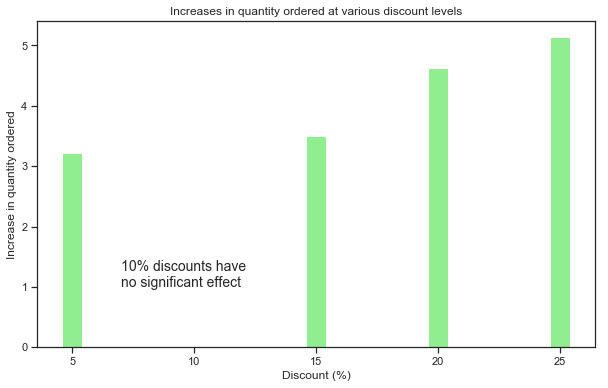

In [94]:
# Get sample means to use in calculating effect sizes
mean_5_discount = np.mean(df_trimmed[df_trimmed.Discount == 0.05]['Quantity'])
mean_10_discount = np.mean(df_trimmed[df_trimmed.Discount == 0.1]['Quantity'])
mean_15_discount = np.mean(df_trimmed[df_trimmed.Discount == 0.15]['Quantity'])
mean_20_discount = np.mean(df_trimmed[df_trimmed.Discount == 0.2]['Quantity'])
mean_25_discount = np.mean(df_trimmed[df_trimmed.Discount == 0.25]['Quantity'])
mean_no_discount = np.mean(df_trimmed[df_trimmed.Discount == 0.0]['Quantity'])

# Organize x-values (discounts) and y-values (effect sizes) for plotting
levels = [5, 10, 15, 20, 25]
means = [mean_5_discount, mean_10_discount, mean_15_discount, mean_20_discount, mean_25_discount]
mean_diffs = [mean - mean_no_discount for mean in means]

# Create a bar plot to show significant effect sizes
plt.figure(figsize=(10, 6))
plt.bar(levels, mean_diffs, color='lightgreen')
plt.bar(x=10, height = mean_10_discount-mean_no_discount, color='white')
plt.xlabel('Discount (%)')
plt.ylabel('Increase in quantity ordered')
plt.title('Increases in quantity ordered at various discount levels')
plt.text(x=7, y=1, s='10% discounts have\nno significant effect', fontsize=14)
plt.show();

Are these effect sizes big, small, or somewhere in between? And what was the power of the statistical test for each of these? Let's examine each discount in turn.

#### Exploring effect sizes and powers

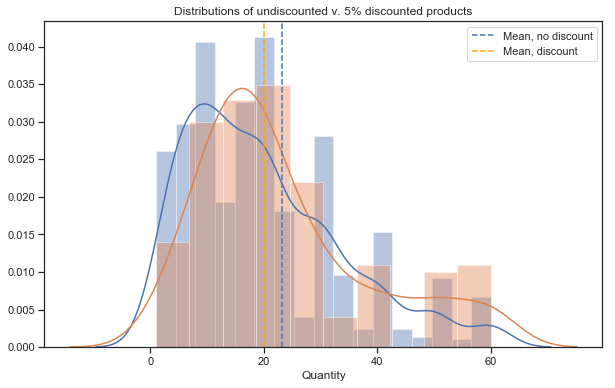

In [100]:
plt.figure(figsize=(10,6))
sns.distplot(df_no_discount.Quantity)
sns.distplot(df_discount[df_discount.Discount == 0.05]['Quantity'])

plt.axvline(x=mean_5_discount, linestyle='--', 
            label='Mean, no discount')
plt.axvline(x=mean_no_discount, linestyle='--', color='orange',
            label='Mean, discount')
plt.legend()
plt.title('Distributions of undiscounted v. 5% discounted products')
plt.show();

In [101]:
stats.levene(df_discount[df_discount.Discount == 0.05]['Quantity'], df_no_discount.Quantity)

LeveneResult(statistic=0.02240733701187282, pvalue=0.8810293663204941)

In [103]:
effect_5 = mean_5_discount - mean_no_discount

d = Cohen_d(df_discount[df_discount.Discount == 0.05]['Quantity'], df_no_discount.Quantity)

power_analysis.solve_power(effect_size=d, alpha=alpha,
                           nobs1=len(df_discount[df_discount.Discount == 0.05]['Quantity']))

0.5586036059740913

For 5% discounts, the power is 0.56, below my chosen threshold of 0.8. 

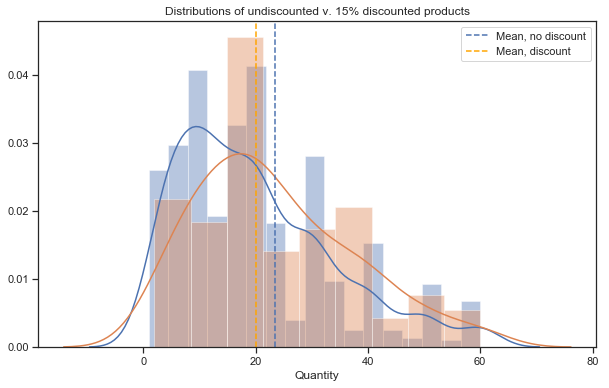

LeveneResult(statistic=0.0693180145704766, pvalue=0.7923704393985946)
Raw effect size: 3.4925627762728304


0.5615151971275081

In [105]:
# Do the same for 15% discount
plt.figure(figsize=(10,6))
sns.distplot(df_no_discount.Quantity)
sns.distplot(df_discount[df_discount.Discount == 0.15]['Quantity'])

plt.axvline(x=mean_15_discount, linestyle='--', 
            label='Mean, no discount')
plt.axvline(x=mean_no_discount, linestyle='--', color='orange',
            label='Mean, discount')
plt.legend()
plt.title('Distributions of undiscounted v. 15% discounted products')
plt.show();

print(stats.levene(df_discount[df_discount.Discount == 0.15]['Quantity'], df_no_discount.Quantity))

effect = mean_15_discount - mean_no_discount
print('Raw effect size:', effect)

d = Cohen_d(df_discount[df_discount.Discount == 0.15]['Quantity'], df_no_discount.Quantity)

power_analysis.solve_power(effect_size=d, alpha=alpha,
                           nobs1=len(df_discount[df_discount.Discount == 0.15]['Quantity']))

Power here is again lower than we would like. There is a high risk of Type II error with 15% discounts. 

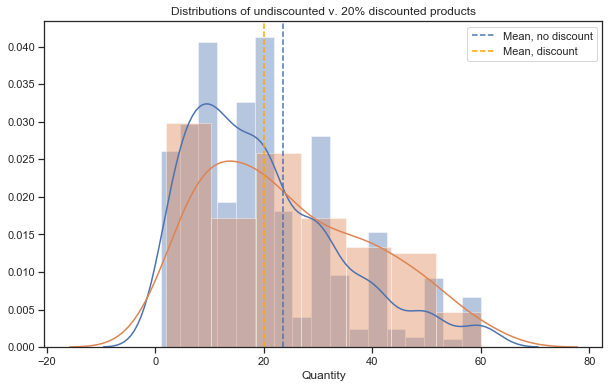

LeveneResult(statistic=4.9602344315708935, pvalue=0.02609132026132316)
Raw effect size: 4.6314239151339684


0.8219594707255559

In [107]:
# Do the same for 20% discount
plt.figure(figsize=(10,6))
sns.distplot(df_no_discount.Quantity)
sns.distplot(df_discount[df_discount.Discount == 0.2]['Quantity'])

plt.axvline(x=mean_15_discount, linestyle='--', 
            label='Mean, no discount')
plt.axvline(x=mean_no_discount, linestyle='--', color='orange',
            label='Mean, discount')
plt.legend()
plt.title('Distributions of undiscounted v. 20% discounted products')
plt.show();

print(stats.levene(df_discount[df_discount.Discount == 0.2]['Quantity'], df_no_discount.Quantity))

effect = mean_20_discount - mean_no_discount
print('Raw effect size:', effect)

d = Cohen_d(df_discount[df_discount.Discount == 0.2]['Quantity'], df_no_discount.Quantity)

power_analysis.solve_power(effect_size=d, alpha=alpha,
                           nobs1=len(df_discount[df_discount.Discount == 0.2]['Quantity']))

Here is the power is above our threshold, but note that the p-value for Levene's test is below 0.05, meaning that non-discounted and 20%-discounted products do not have the same variance. It is probably not appropriate to use Cohen's _d_ to calculate effect size for these samples.

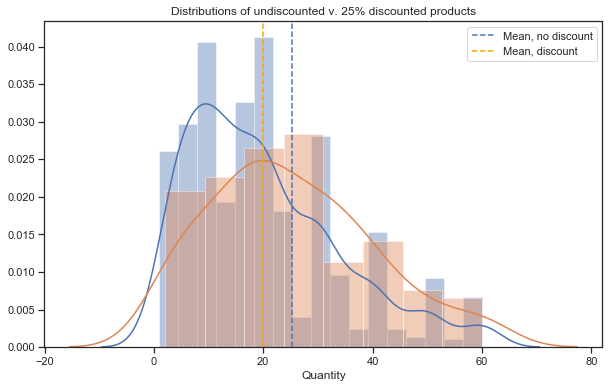

LeveneResult(statistic=2.4127553979598577, pvalue=0.12057210501358487)
Raw effect size: 5.146456827427155


0.8785885476165154

In [108]:
# Do the same for 25% discount
plt.figure(figsize=(10,6))
sns.distplot(df_no_discount.Quantity)
sns.distplot(df_discount[df_discount.Discount == 0.25]['Quantity'])

plt.axvline(x=mean_25_discount, linestyle='--', 
            label='Mean, no discount')
plt.axvline(x=mean_no_discount, linestyle='--', color='orange',
            label='Mean, discount')
plt.legend()
plt.title('Distributions of undiscounted v. 25% discounted products')
plt.show();

print(stats.levene(df_discount[df_discount.Discount == 0.25]['Quantity'], df_no_discount.Quantity))

effect = mean_25_discount - mean_no_discount
print('Raw effect size:', effect)

d = Cohen_d(df_discount[df_discount.Discount == 0.25]['Quantity'], df_no_discount.Quantity)

power_analysis.solve_power(effect_size=d, alpha=alpha,
                           nobs1=len(df_discount[df_discount.Discount == 0.25]['Quantity']))

This is best outcome of all: for 25%-discounted products, we see the biggest effect size (5 more items ordered) and a power above our threshold of 0.8. We can feel confident that 25% discounts really do correspond to customers ordering more of a product, 5 more on average.

Given these outcomes, I would recommend eliminating 10% discounts altogether (or better yet, investigating why they might not be having the intended effect) and perhaps eliminating some of the smaller discount levels to focus on the more effective 25% discount level. Without knowing the profit margins for each product, I can't determine the cost effectiveness of 25% discounts, but if the goal is to increase quantities ordered, that is the best level to use.

## Hypothesis test 1

Does discount amount have a statistically significant effect on the quantity of a product in an order? If so, at what level(s) of discount?

This test uses the following hypotheses to begin with:

H<sub>0</sub>: mean quantity ordered without discount == mean quantity ordered with discount

H<sub>a</sub>: mean quantity ordered without discount < mean quantity ordered with discount

If discounts are determined to have a significant effect on quantity, then I will re-phrase my hypotheses for subsequent tests to determine which specific discount amounts have significant effects on quantity.

This initial test will be a one-tailed test using the following parameters:

In [13]:
# Set alpha and power
alpha = 0.05

power = 0.8

### Prepare the data

I will want to compare quantities ordered with discounts and without discounts, so the data will need to be split into two subsets based on the value in the `Discount` column (0 versus any other value).

In [14]:
# Subset the data based on `Discount`
df_no_discount = df[df.Discount == 0]
df_discount = df[df.Discount != 0]

I will also quickly check the length of each dataset so I will know the sample sizes involved:

In [15]:
print('Size of no-discount sample:', len(df_no_discount))
print('Size of discount sample:', len(df_discount))

Size of no-discount sample: 1317
Size of discount sample: 838


### Inspect the distributions

Next I want to inspect the distributions of products ordered with and without discounts to ensure that they are roughly normal. KDE (kernal density estimation) plots let me see the distributions of values along with probability density curves.

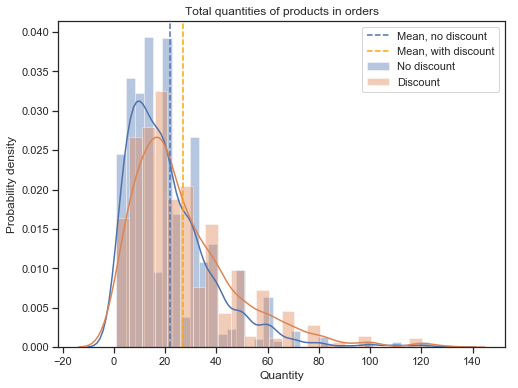

In [16]:
# Create KDE plots of products with and without discounts
plt.figure(figsize=(8,6))
sns.distplot(df_no_discount.Quantity, label='No discount')
sns.distplot(df_discount.Quantity, label='Discount')
plt.axvline(x=np.mean(df_no_discount.Quantity), linestyle='--',
            label='Mean, no discount')
plt.axvline(x=np.mean(df_discount.Quantity), linestyle='--', color='orange',
            label='Mean, with discount')
plt.legend()
plt.title('Total quantities of products in orders')
plt.ylabel('Probability density')
plt.show();

Both distributions (with and without discounts) appear to be roughly normal, although both are right-skewed. I can also see that the two distributions, while overlapping, do appear to be different (and their means are different). What about their variances?

In [17]:
print(np.var(df_no_discount.Quantity))
print(np.var(df_discount.Quantity))

306.2795924332757
430.93782787748984


I will use Levene's test to see whether the difference in variances is significant. The null hypothesis for this test is that the two variances are equal. I will continue to use an alpha value of 0.05 to evaluate the p-value produced by this test.

In [18]:
stats.levene(df_no_discount.Quantity, df_discount.Quantity)

LeveneResult(statistic=14.832671704073421, pvalue=0.00012091378376079568)

With its very low p-value, Levene's test indicates that the variances of `df_no_discount` and `df_discount` are not equal.

Since `df_no_discount` and `df_discount` have different sample sizes, means, and variances, I will use a Welch's t-test to determine whether they are different in terms of `Quantity`.

Before proceeding, I should determine how big of an effect I should be able to observe with samples of the sizes I happen to have. If the calculated effect size is too small to be of interest to my stakeholders, then I should abandon this experiment or get more data.

In [19]:
# Set parameters for use in power analysis
no_disc_std = np.std(df_no_discount.Quantity)
n_no_disc = len(df_no_discount)
disc_std = np.std(df_discount.Quantity)
n_disc = len(df_discount)

In [21]:
# Do power analysis to find minimum effect size for `df_discount`
power_analysis = TTestIndPower()
d_disc = power_analysis.solve_power(nobs1=n_disc, alpha=alpha, power=power)
effect_size_disc = d_disc * disc_std
print(effect_size_disc)

2.842811676794297


The power analysis tells me that, given alpha = 0.05, power = 0.8, and the number of discounted observations I have, I would be able to detect a difference of 2.8 in the mean quantities of discounted and non-discounted items.

If 3 were the minimum difference that would be of interest to my stakeholders, how much power would my statistical test have?

In [22]:
power_analysis.solve_power(nobs1=n_disc, alpha=alpha, effect_size=3/disc_std)

0.8404952770629007

My test should be able to detect an effect size of 3 with a power of 0.84&mdash;better than the 0.8 I require. Now I can move on to the Welch's t-test.

### Perform Welch's t-test

Above I defined a function `run_welch()` to run a Welch's t-test, compare the calculated p-value to my chosen alpha (0.05), and print the result.

In [109]:
# Perform Welch's t-test and print result
run_welch(df_no_discount.Quantity, df_discount.Quantity)

Null hypothesis rejected (p_value = 1.7461160561893507e-07)


The result of the Welch's t-test is that we can reject the null hypothesis; discounts do indeed have a significant effect on the quantity of a product that a customer orders.

This is good to know, but it raises another question: at what level of discount are customers motivated to add more of a product to their carts? And how many more of a given product are they likely to order?

### Try it with ANOVA instead

In [24]:
# Check ANOVA for products with discounts
formula = 'Quantity ~ C(Discount)'

import statsmodels.api as sm
from statsmodels.formula.api import ols

lm = ols(formula, df).fit()
table = sm.stats.anova_lm(lm, typ=2)

In [25]:
table

,sum_sq,df,F,PR(>F)
C(Discount),21258.403604,10.0,6.011811,4.704231e-09
Residual,758141.232591,2144.0,NaN,NaN


### Follow-up: which discount levels motivate customers to buy more of a product?

To answer this question, I want to split the data up by value of `Discount`, run t-tests comparing each discount to the non-discounted products to see if `Quantity` is significantly different, and then report on the effect sizes of any significant differences. For each of these more focused one-tailed t-tests:

H<sub>0</sub>: mean quantity ordered without discount == mean quantity ordered with discount

H<sub>a</sub>: mean quantity ordered without discount < mean quantity ordered with discount

The problem with this approach is that I will be doing multiple comparisons against the same control group (non-discounted products), which increases the likelihood that I'll find a statistically significant difference just by random chance. To avoid this issue, I will use a tool for multiple comparisons called Tukey's HSD (Honestly Significant Difference) test from `statsmodels`. This test will compare all possible combinations of discounts and account for the effects of multiple comparisons so that I can use the same alpha value as before.

First, I should inspect the value counts in the `Discount` column and eliminate any that don't interest me.

In [26]:
# View unique values of `Discount`
df.Discount.value_counts()

0.00    1317
0.05     185
0.10     173
0.20     161
0.15     157
0.25     154
0.03       3
0.02       2
0.01       1
0.04       1
0.06       1
Name: Discount, dtype: int64

It looks like the values that will be most useful to this analysis are 5%, 10%, 15%, 20%, and 25% (and 0%, of course), since there are many instances of each of those. Because the others occur so infrequently, I don't expect to be able to do any meaningful hypothesis testing on them, so it is probably best to just drop those records at this point.

In [27]:
# Drop rows with `Discount` values that occur < 30 times
keepers = [0.0, 0.05, 0.1, 0.15, 0.2, 0.25]

df_2 = df[df.Discount.isin(keepers)]
df_2.Discount.value_counts()

0.00    1317
0.05     185
0.10     173
0.20     161
0.15     157
0.25     154
Name: Discount, dtype: int64

I would like to use Tukey's HSD test for this multiple comparison, but first I need to make sure the test's assumptions are met. The assumptions are:

- the observations are independent of one another;
- observations for each discount level are normally distributed;
- observations for each discount level have equal variance.

I assume that the first assumption holds. To test the second, I will inspect histograms of the observations for each discount level. To test the third, I will do pairwise comparisons of the variances of each discount-sample using the Kruskal-Wallis H test.

In [28]:
# Subset the data by discount value
discount_0 = df_2[df_2.Discount == 0]['Quantity']
discount_5 = df_2[df_2.Discount == 0.05]['Quantity']
discount_10 = df_2[df_2.Discount == 0.1]['Quantity']
discount_15 = df_2[df_2.Discount == 0.15]['Quantity']
discount_20 = df_2[df_2.Discount == 0.2]['Quantity']
discount_25 = df_2[df_2.Discount == 0.25]['Quantity']

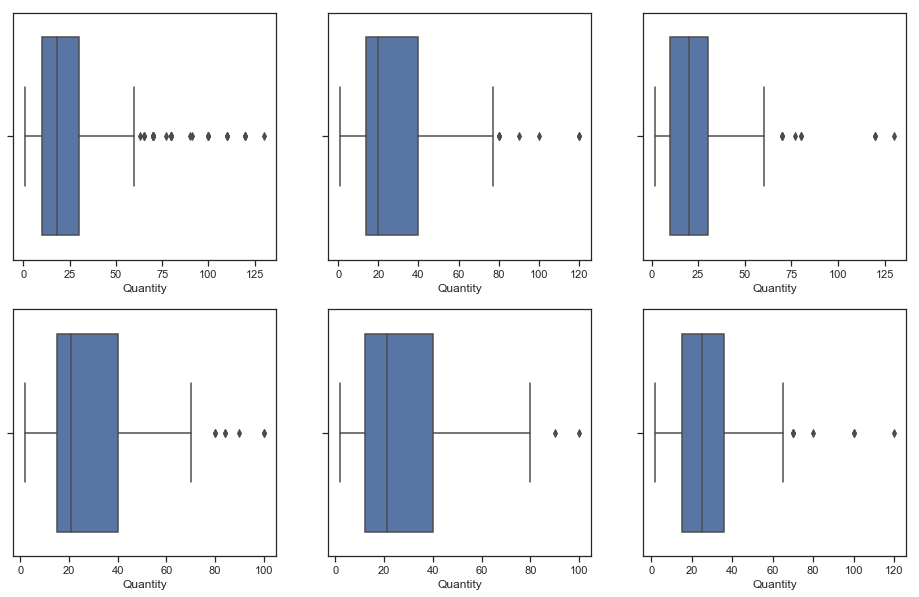

In [29]:
# Compare histograms of each distribution to check for normality
to_hist = [discount_0, discount_5, discount_10, discount_15, discount_20, discount_25]
plt.figure(figsize=(16,10))
for index, data in enumerate(to_hist):
    ax = plt.subplot(2, 3, index+1)
    sns.boxplot(to_hist[index])

plt.show();

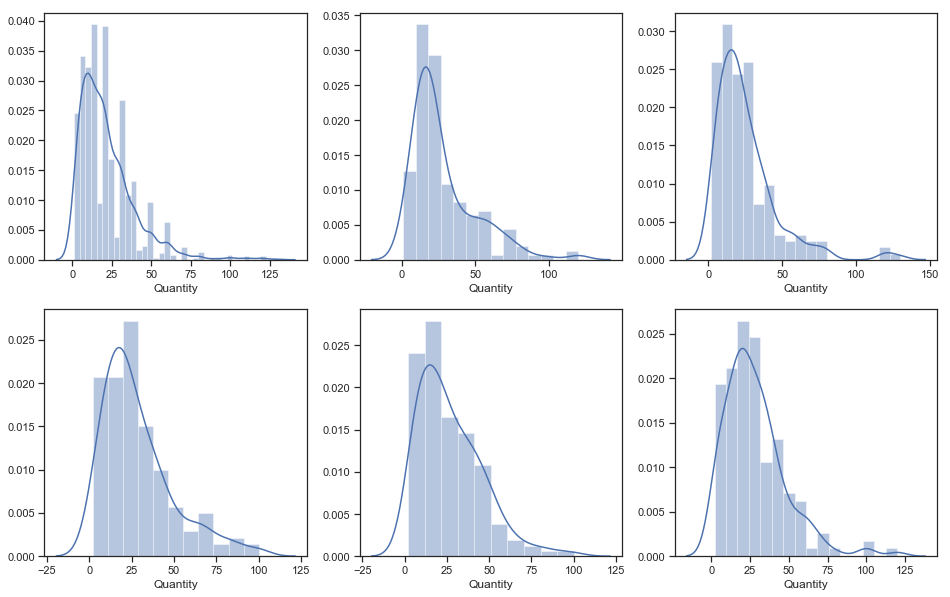

In [30]:
# Compare histograms of each distribution to check for normality
to_hist = [discount_0, discount_5, discount_10, discount_15, discount_20, discount_25]
plt.figure(figsize=(16,10))
for index, data in enumerate(to_hist):
    ax = plt.subplot(2, 3, index+1)
    sns.distplot(to_hist[index])

plt.show();

The observations for each discount level are roughly normally distributed, although right-skewed.

Now to check whether their variances are equal:

In [31]:
stats.kruskal(discount_0, discount_5, discount_10, discount_15, discount_20, discount_25)

KruskalResult(statistic=51.472274060355986, pvalue=6.921091485409491e-10)

The result of the Kruskal-Wallis test, given the very low p-value, is that we must reject the null hypothesis that all these distributions came from the same underlying distribution (i.e., that their variances are equal). Unfortunately, the test doesn't tell me _which_ of the distributions is not like the others. 

In [35]:
# Try the Games-Howell Test
pg.pairwise_gameshowell(data=df_discount, dv='Quantity', between='Discount')

ValueError: cannot convert float NaN to integer

Now I can run the multiple comparison using Tukey's HSD test:

In [23]:
# Initialize the MultiComparison object
MultiComp = MultiComparison(df_2.Quantity, df_2.Discount)

# Print the summary table
print(MultiComp.tukeyhsd().summary())

Multiple Comparison of Means - Tukey HSD,FWER=0.05
group1 group2 meandiff  lower   upper  reject
---------------------------------------------
 0.0    0.05   6.2955   2.0814 10.5097  True 
 0.0    0.1    3.5217  -0.8187  7.8622 False 
 0.0    0.15   6.6669   2.1352 11.1986  True 
 0.0    0.2    5.3096   0.8285  9.7907  True 
 0.0    0.25   6.525    1.954   11.096  True 
 0.05   0.1   -2.7738  -8.4504  2.9028 False 
 0.05   0.15   0.3714  -5.4528  6.1955 False 
 0.05   0.2    -0.986  -6.7708  4.7989 False 
 0.05   0.25   0.2294  -5.6253  6.0842 False 
 0.1    0.15   3.1452   -2.771  9.0613 False 
 0.1    0.2    1.7879  -4.0896  7.6653 False 
 0.1    0.25   3.0033   -2.943  8.9496 False 
 0.15   0.2   -1.3573  -7.3775  4.6628 False 
 0.15   0.25  -0.1419  -6.2292  5.9454 False 
 0.2    0.25   1.2154  -4.8343  7.2652 False 
---------------------------------------------


The first five rows of results are the ones of interest here: they show comparisons between our chosen discount levels and the non-discounted products. The differences between discounted and non-discounted products are statistically significant at all discount levels _except for 10%_. 

Given this outcome, I would recommend eliminating 10% discounts from the discounting strategy. Since 5% and 15% discounts correspond to a similar effect (about 6 more products purchased when compared to non-discounted products), changing any 10% discounts to 5% should result in more products purchased _and_ a bigger profit margin.

Below is a visualization to summarize the findings of this hypothesis test.

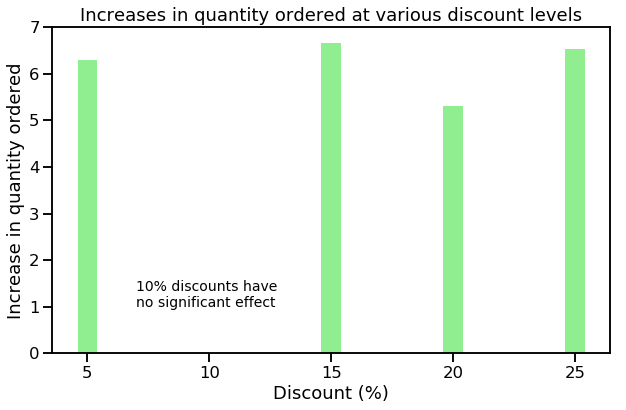

In [24]:
# Get sample means to use in calculating effect sizes
mean_5_discount = np.mean(df_2[df_2.Discount == 0.05]['Quantity'])
mean_10_discount = np.mean(df_2[df_2.Discount == 0.1]['Quantity'])
mean_15_discount = np.mean(df_2[df_2.Discount == 0.15]['Quantity'])
mean_20_discount = np.mean(df_2[df_2.Discount == 0.2]['Quantity'])
mean_25_discount = np.mean(df_2[df_2.Discount == 0.25]['Quantity'])
mean_no_discount = np.mean(df_2[df_2.Discount == 0.0]['Quantity'])

# Organize x-values (discounts) and y-values (effect sizes) for plotting
levels = [5, 10, 15, 20, 25]
means = [mean_5_discount, mean_10_discount, mean_15_discount, mean_20_discount, mean_25_discount]
mean_diffs = [mean - mean_no_discount for mean in means]

# Create a bar plot to show significant effect sizes
plt.figure(figsize=(10, 6))
plt.bar(levels, mean_diffs, color='lightgreen')
plt.bar(x=10, height = mean_10_discount-mean_no_discount, color='white')
plt.xlabel('Discount (%)')
plt.ylabel('Increase in quantity ordered')
plt.title('Increases in quantity ordered at various discount levels')
plt.text(x=7, y=1, s='10% discounts have\nno significant effect', fontsize=14)
plt.show();

## Hypothesis test 2

When discounts are offered, do customers buy more items overall (not just more of the discounted item)?

In the first hypothesis test above, we examined whether discounts were associated with customers buying more of a (discounted) product. But this test didn't account for the total quantity of items in an order. When customers receive a discount on some of their items, do they then purchase more items overall? Or do they buy more of the discounted item and fewer other items to compensate? 

It makes sense that discounting would correspond to increases in overall order size, but if for some reason it <em>didn't</em>, we would want to know so we could investigate further.

For this one-tailed test, the hypotheses will be the following:

H<sub>0</sub>: mean total quantity for orders without discounts == mean total quantity for orders with discounts

H<sub>a</sub>: mean total quantity for orders without discounts < mean total quantity for orders with discounts

Alpha (0.05) and power (0.8) will remain the same.

### Prepare the data

For this test, the data will need to be grouped by order and split into orders where one or more products are discounted and orders where no products are discounted.

The `Discount_bool` column created earlier will come in handy for partitioning the dataset.

In [25]:
# Get list of orders where no items are discounted
group_by_discount_bool = pd.DataFrame(df.groupby('OrderId')['Discount_bool'].sum())
ids_no_disc = group_by_discount_bool[group_by_discount_bool.Discount_bool == 0]
ids_no_disc = list(ids_no_disc.index)

In [26]:
# Get list of orders with at least one discounted item
ids_with_disc = group_by_discount_bool[group_by_discount_bool.Discount_bool > 0]
ids_with_disc = list(ids_with_disc.index)

In [27]:
# Confirm that there is no overlap between the lists of ids
# (Nothing should print)
for item in ids_no_disc:
    if item in ids_with_disc:
        print(item)
        
for item in ids_with_disc:
    if item in ids_no_disc:
        print(item)

In [28]:
# Subset products by whether they occur in orders with discounts or not
orders_discount = df[df.OrderId.isin(ids_with_disc)]
orders_no_discount = df[df.OrderId.isin(ids_no_disc)]

In [29]:
# Group by order; these orders contain ONE OR MORE discounted items
orders_discount = orders_discount.groupby('OrderId')['Quantity'].sum()
print(orders_discount.head())
print('Sample size:', len(orders_discount))

OrderId
10250     60
10251     41
10252    105
10254     57
10258    121
Name: Quantity, dtype: int64
Sample size: 380


In [30]:
# Group by order; these orders contain NO discounted items
orders_no_discount = orders_no_discount.groupby('OrderId')['Quantity'].sum()
print(orders_no_discount.head())
print('Sample size:', len(orders_no_discount))

OrderId
10248     27
10249     49
10253    102
10255    110
10256     27
Name: Quantity, dtype: int64
Sample size: 450


### Inspect the distributions

First, let's visually inspect the distributions:

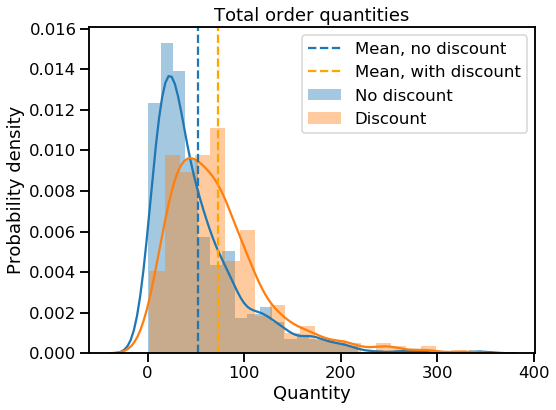

In [31]:
# Create KDE plots of products with and without discounts
plt.figure(figsize=(8,6))
sns.distplot(orders_no_discount, label='No discount')
sns.distplot(orders_discount, label='Discount')
plt.axvline(x=np.mean(orders_no_discount), linestyle='--',
            label='Mean, no discount')
plt.axvline(x=np.mean(orders_discount), linestyle='--', color='orange',
            label='Mean, with discount')
plt.legend()
plt.title('Total order quantities')
plt.ylabel('Probability density')
plt.show();

Both distributions (with and without discounts) appear to be roughly normal, although both are right-skewed. I can also see that the two distributions, while overlapping, do appear to be different (and their means are different). What about their variances?

In [32]:
print(np.var(orders_no_discount))
print(np.var(orders_discount))

2326.464177777778
2635.4101038781164


In [33]:
stats.levene(orders_no_discount, orders_discount)

LeveneResult(statistic=1.9179524407508215, pvalue=0.16645558467542218)

Since `orders_no_discount` and `orders_discount` have different sample sizes, means, and variances, I will use a Welch's t-test to determine whether they are different in terms of `Quantity`.

Before proceeding, I should check two things: 
- that the mean total quantities of items in orders, when sampled many times, form a normal distribution;
- that the two sample sizes are big enough to let me observe a difference of a certain size.

First up: checking the distribution of sample means:

In [34]:
# Get a list of all orders' total quantities
all_orders = pd.concat([orders_discount, orders_no_discount])
print(all_orders[:10])
print(len(all_orders))

OrderId
10250     60
10251     41
10252    105
10254     57
10258    121
10260    102
10262     29
10263    184
10264     60
10266     12
Name: Quantity, dtype: int64
830


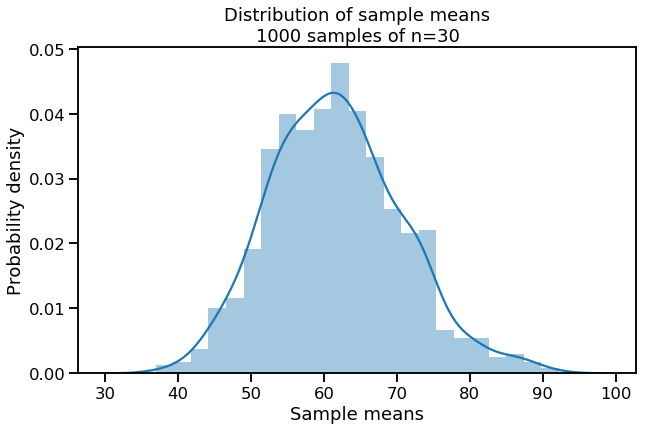

In [35]:
# Plot the means of 1000 samples of size 30
sample_means = []
for n in range(1000):
    sample = np.random.choice(all_orders, 30)
    mean = np.mean(sample)
    sample_means.append(mean)

plt.figure(figsize=(10,6))
sns.distplot(sample_means)
plt.xlabel('Sample means')
plt.ylabel('Probability density')
plt.title('Distribution of sample means\n1000 samples of n=30')
plt.show();

That looks pretty normal. I will assume that the data is independent and reasonably random as well.

And now to see what effect sizes I can expect given the sample sizes I have. Given the smaller numbers of observations now that the data is grouped into orders, I will have to settle for a larger effect size of at least 11, keeping alpha at 0.05 and power at 0.8.

In [36]:
# Calculate Cohen's d
effect_size = 10.5
pop_std = np.std(df.groupby('OrderId')['Quantity'].sum())

d = effect_size / pop_std
print('Cohen\'s d:', d)

Cohen's d: 0.20702881324258446


In [37]:
# Use power analysis to find sample size needed
power_analysis = TTestIndPower()
power_analysis.solve_power(effect_size=d, alpha=alpha, power=power)

367.2106371060832

I should be able to observe an effect size of at least 10.5 (more items added to a customer's order) with the sample sizes I have (380 and 450, calculated above). Time to move on to a Welch's t-test.

### Perform Welch's t-test

Now I can run a Welch's t-test to compare the total quantities of items in orders with and without discounts to see if they are significantly different.

In [38]:
# Perform Welch's t-test
run_welch(orders_no_discount, orders_discount)

Null hypothesis rejected (p_value = 2.9253389710603983e-09)


In rejecting the null hypothesis, we are finding that when a discount is applied to any item in an order, customers tend to buy more items overall. This is what we hoped to find, and it confirms that discounting is an effective strategy for increasing the quantities of products sold. 

Let's see how big the effect is:

In [39]:
# Calculate effect size
np.mean(orders_discount) - np.mean(orders_no_discount)

20.50473684210526

That's 20.5 more items per order on average when any item in an order has been discounted. Note that this is a bigger effect than the one we saw earlier. Customers buy only about 5 to 6 more of a particular item when it is discounted, but they buy about 20 more items on average&mdash;both discounted and non-discounted ones&mdash;when at least one item in their cart comes with a discount.

The plot below summarizes this finding. Based on this hypothesis test, I would recommend determining the most popular items and consistently offering discounts on those, since the presence of any discounted item in an order corresponds to more items ordered overall.

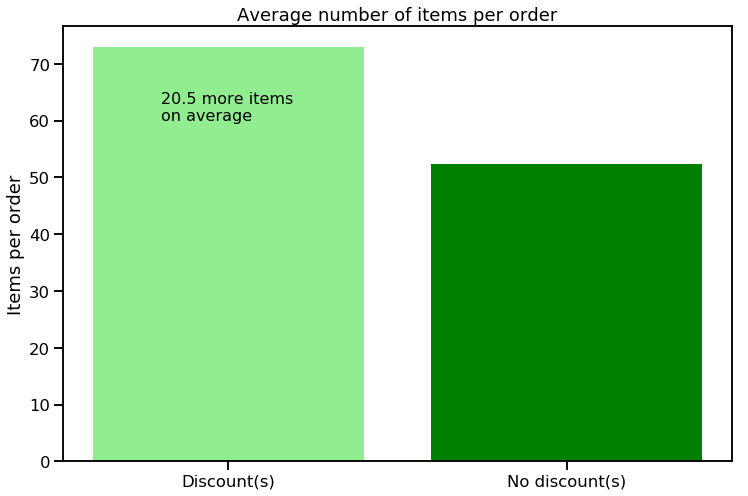

In [40]:
# Plot mean item counts for orders with and without discounts
y_values = [np.mean(orders_discount), np.mean(orders_no_discount)]
x_values = ['Discount(s)', 'No discount(s)']

plt.figure(figsize=(12,8))
plt.bar(x_values, y_values, color='green')
plt.bar(x_values[0], y_values[0], color='lightgreen')
plt.text(x=-0.20, y=60, s='20.5 more items\non average', fontsize=16)
plt.ylabel('Items per order')
plt.title('Average number of items per order')
plt.show();

## Hypothesis test 3

When discounts are offered, do customers actually spend more per order?

The previous test showed that customers tend to buy more items when discounts are offered, but are they actually spending more? Although that seems likely, it would be worthwhile to know for certain whether the total dollar amounts of orders with discounts are higher than those without discounts, and by how much.

For this one-tailed test, the hypotheses will be the following:

H<sub>0</sub>: mean total dollar amount of orders without discounts == mean total dollar amount of orders with discounts

H<sub>a</sub>: mean total dollar amount of orders without discounts < mean total dollar amount of orders with discounts

Alpha (0.05) and power (0.8) will remain the same.

### Prepare the data

To prepare the data for analysis, I first need to repeat some steps from the last test to split the data into orders that contain no discounted items and orders that contain one or more discounted items.

In [41]:
# Subset products by whether they occur in orders with discounts or not
orders_discount = df[df.OrderId.isin(ids_with_disc)]
orders_no_discount = df[df.OrderId.isin(ids_no_disc)]

In [42]:
# Group by order; these orders contain ONE OR MORE discounted items
orders_discount = orders_discount.groupby('OrderId')['ProductTotal'].sum()
print(orders_discount.head())
print('Sample size:', len(orders_discount))

OrderId
10250    1552.60
10251     654.06
10252    3597.90
10254     556.62
10258    1614.88
Name: ProductTotal, dtype: float64
Sample size: 380


In [43]:
# Group by order; these orders contain NO discounted items
orders_no_discount = orders_no_discount.groupby('OrderId')['ProductTotal'].sum()
print(orders_no_discount.head())
print('Sample size:', len(orders_no_discount))

OrderId
10248     440.0
10249    1863.4
10253    1444.8
10255    2490.5
10256     517.8
Name: ProductTotal, dtype: float64
Sample size: 450


This time I have aggregated on the `ProductTotal` column, which contains the unit price times quantity times any discount to equal the price charged for each product in an order. The values in the series `orders_discount` and `orders_no_discount` represent the sums of the costs of all products in each order.

### Inspect the distributions

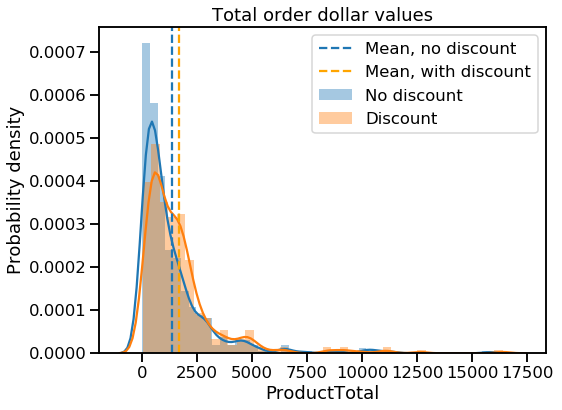

In [44]:
# Create KDE plots of products with and without discounts
plt.figure(figsize=(8,6))
sns.distplot(orders_no_discount, label='No discount')
sns.distplot(orders_discount, label='Discount')
plt.axvline(x=np.mean(orders_no_discount), linestyle='--',
            label='Mean, no discount')
plt.axvline(x=np.mean(orders_discount), linestyle='--', color='orange',
            label='Mean, with discount')
plt.legend()
plt.title('Total order dollar values')
plt.ylabel('Probability density')
plt.show();

Both distributions (with and without discounts) appear to be roughly normal, although both are right-skewed. I can also see that the two distributions, while overlapping, do appear to be different (and their means are different). What about their variances?

In [45]:
print(np.var(orders_no_discount))
print(np.var(orders_discount))

3206922.148851487
3571935.418875696


In [46]:
stats.levene(orders_no_discount, orders_discount)

LeveneResult(statistic=0.7142671292235668, pvalue=0.3982749993804965)

Since `orders_no_discount` and `orders_discount` have different sample sizes, means, and variances, I will use a Welch's t-test to determine whether they are different in terms of `ProductTotal`.

Before proceeding, I should check two things: 
- that the mean total dollar values of orders, when sampled many times, form a normal distribution;
- that the two sample sizes are big enough to let me observe a difference of a certain size.

First up: checking the distribution of sample means:

In [47]:
# Get a list of all orders' total quantities
all_orders = pd.concat([orders_discount, orders_no_discount])
print(all_orders[:10])
print(len(all_orders))

OrderId
10250    1552.600
10251     654.060
10252    3597.900
10254     556.620
10258    1614.880
10260    1504.650
10262     584.000
10263    1873.800
10264     695.625
10266     346.560
Name: ProductTotal, dtype: float64
830


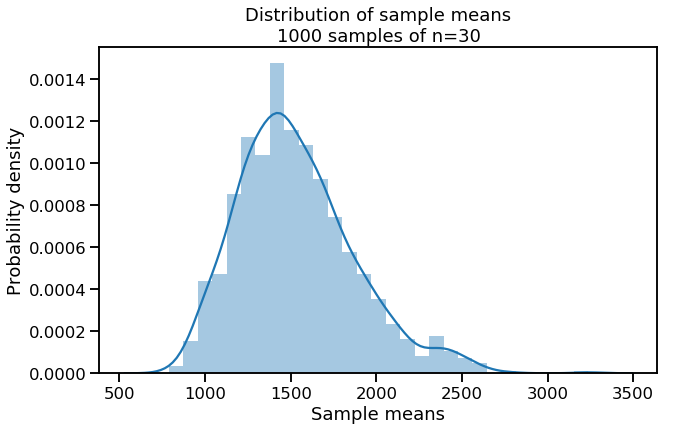

In [48]:
# Plot the means of 1000 samples of size 30
sample_means = []
for n in range(1000):
    sample = np.random.choice(all_orders, 30)
    mean = np.mean(sample)
    sample_means.append(mean)

plt.figure(figsize=(10,6))
sns.distplot(sample_means)
plt.xlabel('Sample means')
plt.ylabel('Probability density')
plt.title('Distribution of sample means\n1000 samples of n=30')
plt.show();

That looks pretty normal (although a little skewed to the right). I will assume that the data is independent and reasonably random as well.

And now to see what effect sizes I can expect given the sample sizes I have. Given the smaller numbers of observations now that the data is grouped into orders, I will have to settle for a larger effect size of at least 376, keeping alpha at 0.05 and power at 0.8.

In [49]:
# Calculate Cohen's d
effect_size = 376
pop_std = np.std(df.groupby('OrderId')['ProductTotal'].sum())

d = effect_size / pop_std
print('Cohen\'s d:', d)

Cohen's d: 0.20389717936588783


In [50]:
pop_std

1844.0667064122472

In [51]:
# Use power analysis to find sample size needed
power_analysis = TTestIndPower()
power_analysis.solve_power(effect_size=d, alpha=alpha, power=power)

378.547276897468

I should be able to observe an effect size of at least 376 (more dollars spent per order on average) with the sample sizes I have (380 and 450, calculated above). Time to move on to a Welch's t-test.

### Perform Welch's t-test

Now I can run a Welch's t-test to determine whether there is a significant difference between the mean total dollar amounts of orders with and without discounts.

In [52]:
# Perform Welch's t-test and print the results
run_welch(orders_no_discount, orders_discount)

Null hypothesis rejected (p_value = 0.005626924599663519)


The results of the t-test indicate that we can reject the null hypothesis; there is indeed a significant difference between the mean total dollar amounts of orders with and without discounts.

How big is that difference?

In [53]:
# Calculate effect size
np.mean(orders_discount) - np.mean(orders_no_discount)

327.02002266081854

Orders with discounts amount to \\$327.02 more on average than orders without discounts. This calculation does not account for the value of discounts in an order, just their presence. For instance, some orders may include only items with large discounts, while other orders may have many non-discounted items and only one item discounted at a low value (e.g., 5\%). This calculation tells us, however, that orders including at least one discounted item can bring in over $300 more in gross revenue on average than orders where no item has been discounted. 

Having seen these results, I would reiterate my recommendation from the previous test. Getting a discounted item into every shopping cart should be a priority, and the most convenient way to do that may be to offer small discounts year-round on the most popular items.

In [54]:
plt.bar(popular_indices, df.ProductId.value_counts()[:10])

NameError: name 'popular_indices' is not defined

In [ ]:
popular_indices = ['59', '31', '24', '60', '56', '62', '41', '75', '2', '16']
# popular = [df[df.ProductId == index] for index in popular_indices]

rows = []
for index in popular_indices:
    print(df[df.ProductId == index])

## Hypothesis test 4

Put the motivating question here.

Hypotheses

### Prepare the data

In [ ]:
#

### Inspect the distributions

### Perform Welch's t-test

In [ ]:
#

# Interpretation and recommendations

Given the outcome of Hypothesis Test 1, I would recommend eliminating 10% discounts from the discounting strategy. Since 5% and 15% discounts correspond to a similar effect (about 6 more products purchased when compared to non-discounted products), changing any 10% discounts to 5% should result in more products purchased and a bigger profit margin.

Based on Hypothesis Test 2, I would recommend determining the most popular items and consistently offering discounts on those, since the presence of any discounted item in an order corresponds to more items ordered overall.

Having seen the results of Test 3, I would reiterate my recommendation from the previous test. Getting a discounted item into every shopping cart should be a priority, and the most convenient way to do that may be to offer small discounts year-round on the most popular items.